In [69]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('apw-notebook.mplstyle')
%matplotlib inline
import sklearn
from astropy.table import Table

# Machine Learning: Introduction

I think of machine learning as a set of algorithms and implementations that make data-driven predictions or decisions. This is why machine learning has become all the buzz in industry, but isn't always applicable in scientific studies; we're often interested in making some inference about a parameter after marginalizing over nuisance parameters so we can learn some thing about "physics." (We're usually not trying to serve ads to teenagers.) Another reason that machine learning algorithms are not obviously applicable to science is that the rarely incorporate observational uncertainties in a justifiable way. More on that later...

The typical problems for which you might consider using machine learning methods can be grouped into four main types of problems:

* **Classification**: I have photometry for 100,000 sources from some imaging survey and I want to know which ones are galaxies, stars, quasars
* **Regression**: I want to learn the parameters of some model, usually so I can make good predictions.
* **Dimensionality reduction**: I have spectra for 100,000 galaxies and I want to decompose the spectra into a mixture of stellar population models.
* **Clustering**: I have colors, sizes, and shapes for 100,000 galaxies and I want to know if there are sub-populations with similar characteristics.

These classes of problems can be further split into two main categories:

* **Supervised learning**: *Classification* and *regression* problems, where you have some set of "features" and some known "labels" for (a subset of) the data. That is, for a subset of the data, we know the true classes or true values. In the first example above, the photometry or colors are the features and the label can be "galaxy", "star", or "quasar". In the case of regression, the labels can be continuous.
* **Unsupervised learning**: *Dimensionality reduction* and *clustering* problems, where you only have a set of "features" and you'd like to find similarities between in order to compress or cluster the data, blindly.

For all of the above, there are many, many algorithms and options within the options. Often, there is no definitive answer or easy way to determine what algorithm will perform best for your use case. It generally takes a lot of trial and error, and help from experts! In some cases, you get the best performance from using *many algorithms simultaneously* and combining the predictions / results (see: Netflix prize).

Luckily, most of the relevant algorithms are implemented in the Python package `scikit-learn` and have a common interface for interacting with them. This makes it fairly easy to write code that is "learning algorithm agnostic," meaning you can swap in and out different methods as you change your mind. The `scikit-learn` developers have also created a rough cheat sheet for algorithms:

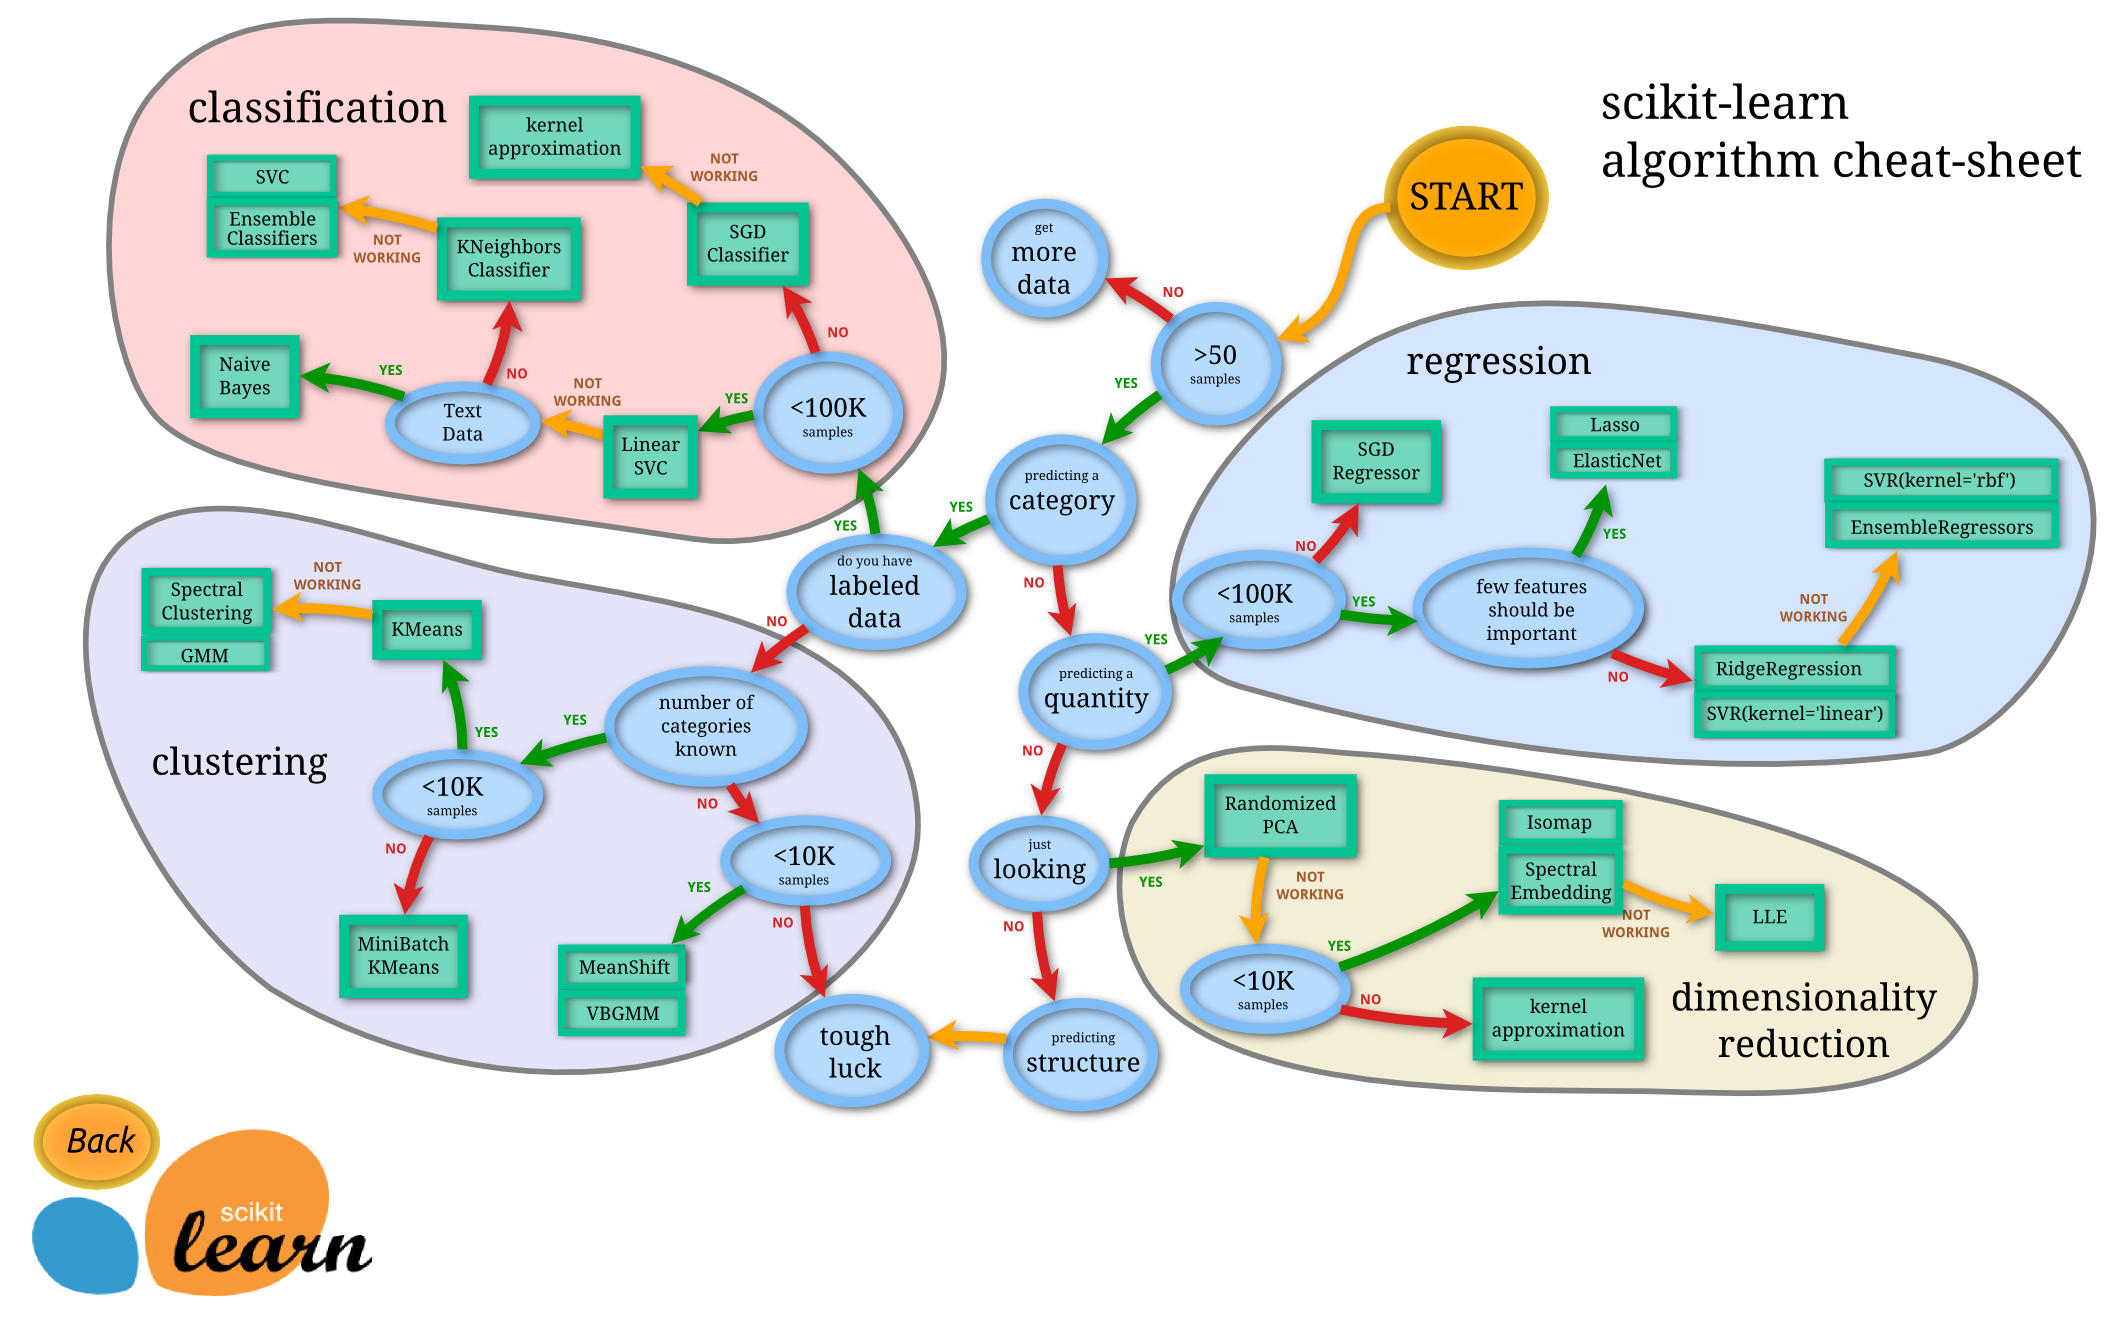

In [2]:
from IPython import display
display.Image('http://scikit-learn.org/stable/_static/ml_map.png')

# Scikit-learn

All of the algorithms in `scikit-learn` have a unified interface for fitting to data and evaluating models. The `scikit-learn` classes expect you to format your data into two numpy arrays: the array of *feature vectors*, `X`, and (if doing supervised learning) the *label vector*, `y`. We'll see examples of how to use these classes below, but here I'll just show an example of how to format your data into these two arrays using one of the demo datasets provided with `scikit-learn`:

In [8]:
from sklearn.datasets import load_iris

In [13]:
iris = load_iris()
X = iris.data
y = iris.target

`X` is the feature vector array, a 2D array with shape (number of datapoints, number of features):

In [17]:
X.shape

(150, 4)

So, this dataset contains 150 measurements of 4 features for Irises (flowers): Sepal Length, Sepal Width, Petal Length and Petal Width. Associated with each measurement is a label that designates the type of Iris:

In [18]:
y.shape, np.unique(y)

((150,), array([0, 1, 2]))

There are only 3 unique labels (0, 1, 2), so there are only 3 classes.

### Exercise: read in the table of SDSS photometry and format it into feature and label arrays

The table contains some photometry (g,r,i magnitudes) and other columns -- create a feature array containing the g, r, i magnitudes and the colors (g-r), (r-i), (g-i) (a total of 6 features). Create a label array using the column 'type', which is either 0 (star) or 1 (galaxy).

In [21]:
filename = '../data/sdss.fit'

In [19]:
# TODO: fill in here (hint: use Table.read() to load the file)

---

# Classification

The goal of a classification problem is to train a model that will successfully predict the classes of new objects that I feed in to the model. Let's stick with the idea of classifying photometric objects as an example. Imagine we have a huge database of photometry for astronomical objects, and for some subset of that database I've gone through by hand and classified the data into two classes: "star" and "galaxy." I don't want to have to go through the whole dataset and label all of the targets, instead I want to train the computer to learn the best way to discriminate these classes based on the smaller *training set* of data that I provide.

A generic problem for any machine learning application is: How do we decide on the model? As mentioned above, that often comes from a mixture of "physical intuition," trial and error, and computational cost. You first have to decide on an algorithm. To do that, you have to think about what accuracy you want, how flexible / nonlinear the model can be (e.g., number of parameters), how much time and data it will take to train the model. Once we choose an algorithm, we then need to figure out a way to determine a "score" for a given choice of parameters. Lastly, we need to decide on how we're going to optimize over the model parameters.

There are many models / algorithms out there. To name a few:
* Nearest neighbors
* Support vector machines
* Decision trees / random forest 
* Neural networks

As a demonstration, here we'll use the K nearest-neighbors algorithm to train a model to predict whether a photometric measurement is a star or a galaxy:

In [34]:
from sklearn.neighbors import KNeighborsClassifier

Convention is to define the classifier object as "`clf`". For the simplest version of this algorithm, it has 1 tunable parameter: the number of neighbors K to consider.

In [36]:
clf = KNeighborsClassifier(n_neighbors=5)

Let's start by fitting the classifier to all but the last 128 data points, then predict the classes of the last data points:

In [54]:
clf.fit(X[:-8], y[:-8])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [55]:
print("Predicted:", clf.predict(X[-8:]))
print("True:     ", y[-8:])

Predicted: [1 0 1 1 0 1 1 1]
True:      [1 0 1 0 0 1 0 1]


Nice, our predictions are pretty good! We can compute a "misclassification error" from the differences between the
predicted classes and the truth:

In [56]:
from sklearn.metrics import accuracy_score

In [58]:
misclassification_error = (clf.predict(X[-8:]) - y[-8:]).sum() / len(y[-8:])
accuracy = 1 - misclassification_error
accuracy

0.75

### Exercise: 

Train on all but the last 128 data points, then predict the classes for those last 128 points. What is the accuracy using `n_neighbors=5`? How about setting it to [2, 4, 8, 16, 32]? When do you get the best accuracy?

In [59]:
# TODO: fill in here

---

# Cross-validation

Cross-validation provides a way to tune or set hyperparameters of machine learning algorithms. The way these methods generally work is by training the model on some subset of the full training set, predicting the labels of the held-back data, computing an accuracy metric by comparing to the true labels, then optimizing. It's basically an automated way of what we did by eye above. This helps protect against underfitting and overfitting. The held-back data is often called the *test data*.

In [60]:
from sklearn.model_selection import cross_val_score

In [71]:
vals = np.arange(2, 100, 5)
mean_scores = []
for n_neighbors in vals:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(clf, X, y)
    mean_scores.append(np.mean(scores))

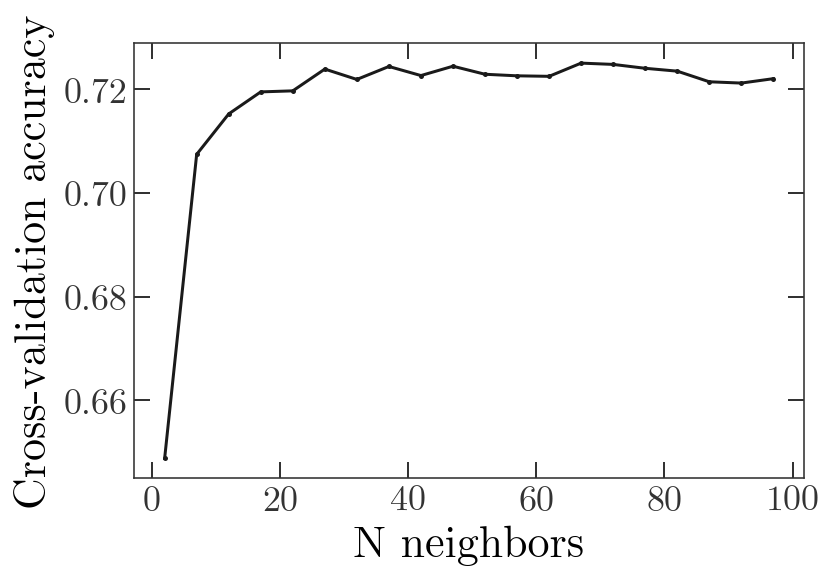

In [72]:
plt.plot(vals, mean_scores)
plt.xlabel('N neighbors')
plt.ylabel('Cross-validation accuracy')

Scikit-learn has a utility that will automatically do the optimization for you:

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
knn_clf = KNeighborsClassifier()

In [92]:
train_X = X[:-1024]
train_y = y[:-1024]
test_X = X[-1024:]
test_y = y[-1024:]

In [93]:
params = {'n_neighbors': np.arange(2, 100, 2)}
cv_clf = GridSearchCV(knn_clf, param_grid=params)
cv_clf.fit(train_X, train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68,
       70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [97]:
cv_clf.best_score_

0.7240198145025295

(23, 14)

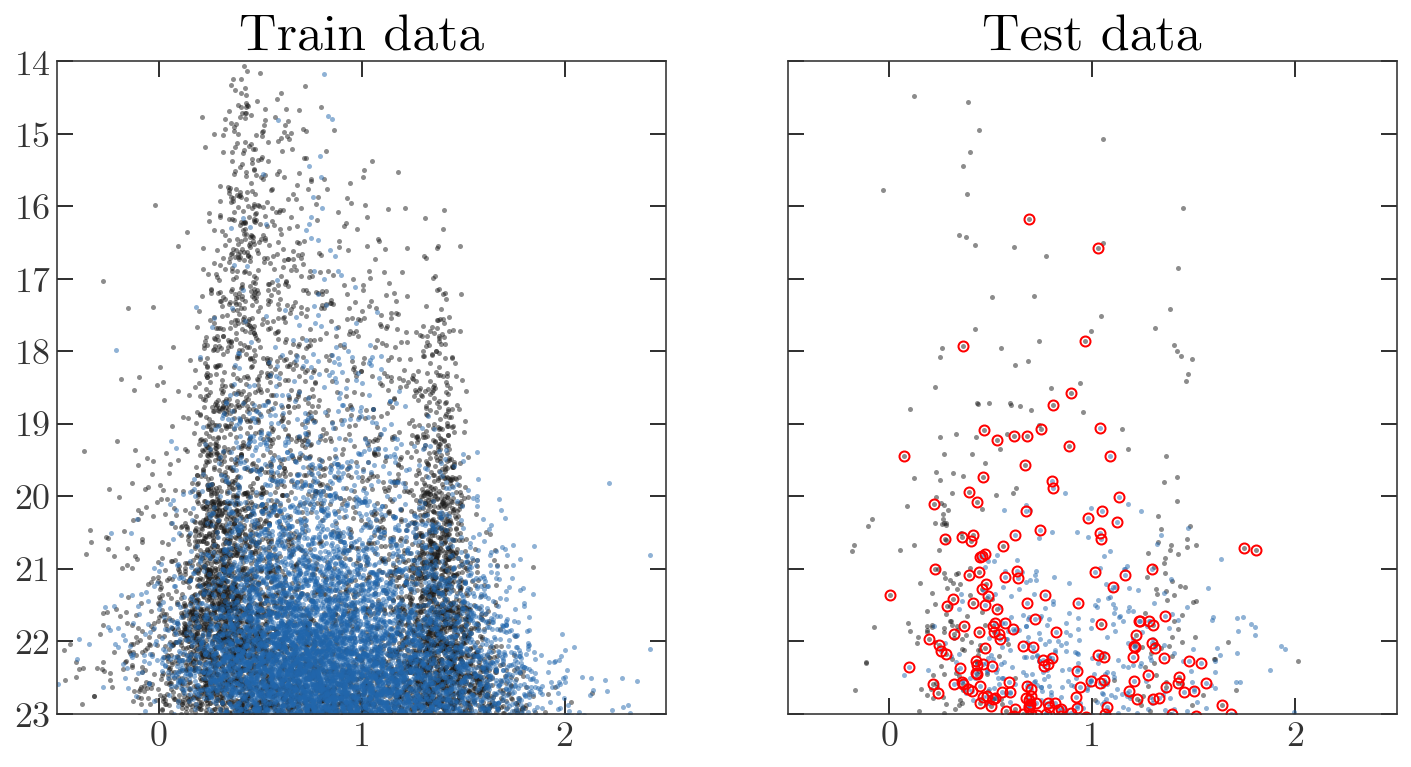

In [96]:
y_predicted = cv_clf.predict(test_X)

fig,axes = plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=True)

ax = axes[0]
ax.plot(train_X[train_y==0,3], train_X[train_y==0,0], 
        marker='.', linestyle='', alpha=0.5, label='stars')
ax.plot(train_X[train_y==1,3], train_X[train_y==1,0], 
        marker='.', linestyle='', alpha=0.5, label='galaxies')
ax.set_title("Train data")

ax = axes[1]
ax.plot(test_X[y_predicted==0,3], test_X[y_predicted==0,0], 
        marker='.', linestyle='', alpha=0.5)
ax.plot(test_X[y_predicted==1,3], test_X[y_predicted==1,0], 
        marker='.', linestyle='', alpha=0.5)
ax.plot(test_X[test_y!=y_predicted,3], test_X[test_y!=y_predicted,0], 
        marker='o', linestyle='', alpha=1., markerfacecolor='none',
        markeredgewidth=1, markeredgecolor='r')
ax.set_title("Test data")

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(23, 14)

### Exercise: 

Repeat the cross-validation above using a Support Vector Machine classifier instead. This classifier has a few parameters, but we'll just tune 1: the parameter `C`. Use `GridSearchCV` to try C = [1,10,100,1000]. What is the best score?

In [98]:
from sklearn.svm import SVC

In [99]:
svm_clf = SVC()

In [100]:
# TODO: fill in here

In [104]:
# TODO: make the same plot as above, but for the cross-validated SVM classifier